# Spectral Clustering Works

Spectral clustering groups data by looking at the "shape" of connections among points rather than raw coordinates. It treats data as a graph and uses eigenvectors of a graph Laplacian to reveal cluster structure.

It is particularly useful when the structure of the individual clusters is highly irregular or more complex than globular shapes (e.g., circle). It's also useful for clustering graphs (like social networks). However, it can be computationally expensive for very large datasets and sensitive to the choice of similarity metric and the number of clusters specified.

### Core idea 
1. Build a similarity graph:
   - Nodes = data points; edges connect nearby points (e.g., k-nearest neighbors or within a radius).
   - Edge weights reflect similarity (e.g., larger when points are close).
2. Compute the graph Laplacian $L$:
   - Let $W$ be the weighted adjacency (similarity) matrix and $D$ be the degree matrix.
   - Unnormalized Laplacian: $L = D − W$. Normalized options also exist ($L_{sym}$, $L_{rw}$).
3. Find the first $k$ eigenvectors of $L$ (associated with the smallest eigenvalues):
   - Stack these eigenvectors column-wise → a new k-dimensional embedding ("spectral space").
4. Run a simple algorithm (often K-means) on the spectral embedding to obtain $k$ clusters.

This procedure excels when clusters are non-convex (e.g., two interleaving moons) where distance-based algorithms struggle.

### Analogy in mechanical systems
- Think of data points as masses and similarities as springs connecting nearby masses. The graph Laplacian plays a role similar to a stiffness matrix.
- The eigenvectors of the Laplacian are like mode shapes of a mass–spring network. Low-frequency modes vary slowly across strongly connected regions and change rapidly across weak connections.
- When the graph naturally splits into groups with weak coupling between them, the lowest modes become "piecewise smooth" over each group—making them separable by a simple method like K-means in the spectral space.
- Related intuition: diffusion/heat flow on the graph mixes quickly within clusters and slowly across clusters; the Laplacian’s spectrum captures these mixing times.

Below, the examples demonstrate these ideas on classic non-convex datasets.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets

# Consistent plotting style
sns.set_theme(font_scale=1.2)
sns.set_style("whitegrid", {"grid.linestyle": "--"})
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
random_state = 42
np.random.seed(42)

n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

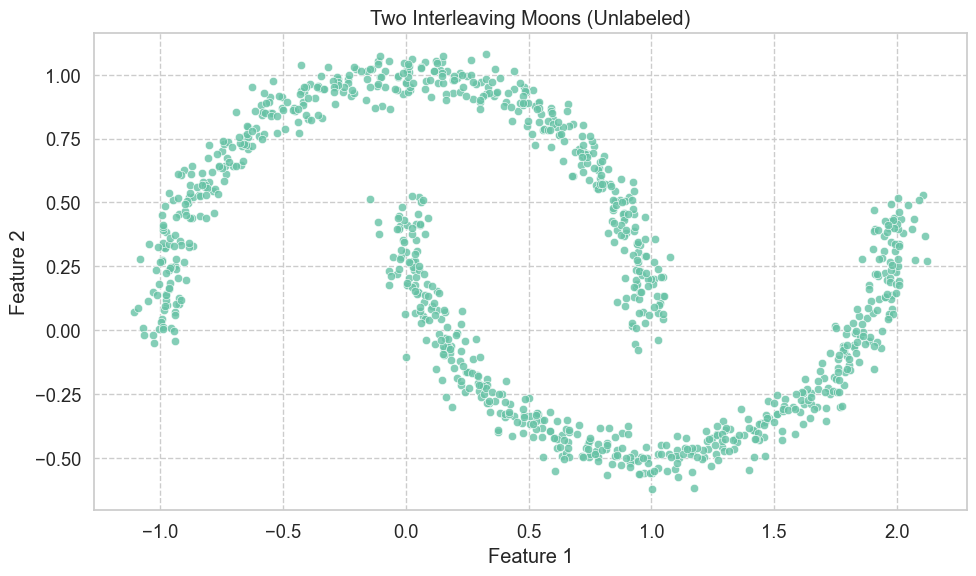

In [3]:
# Noisy moons (unlabeled)
X_moons = np.asarray(noisy_moons[0])

plt.figure()
sns.scatterplot(x=X_moons[:, 0], y=X_moons[:, 1], alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two Interleaving Moons (Unlabeled)")
plt.tight_layout()
plt.show()

/Users/changyaochen/Projects/MECE4520/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


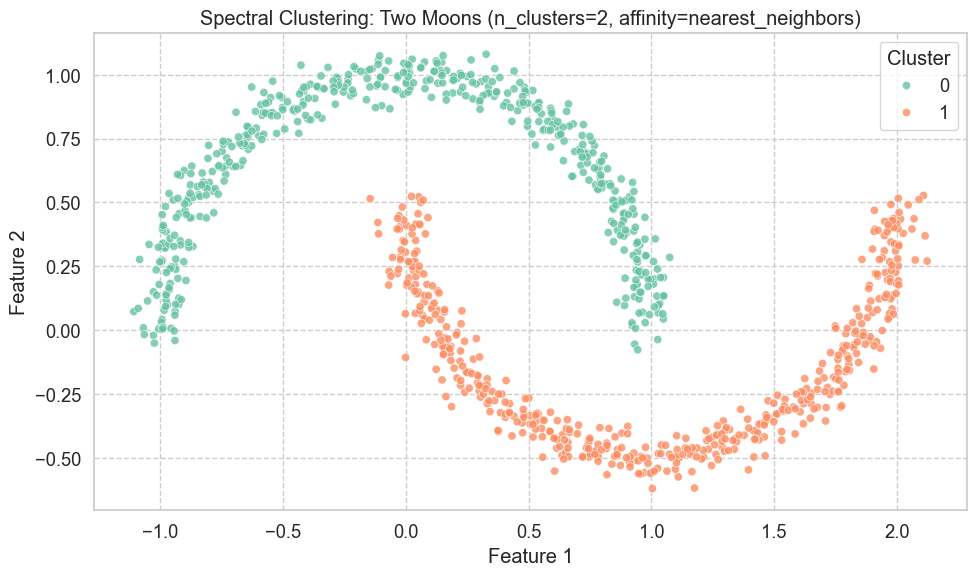

In [4]:
# Spectral clustering on moons with scikit-learn
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    random_state=42
)
labels = sc.fit_predict(noisy_moons[0])

plt.figure()
sns.scatterplot(
    x=X_moons[:, 0],
    y=X_moons[:, 1],
    hue=labels,
    alpha=0.8
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Spectral Clustering: Two Moons (n_clusters=2, affinity=nearest_neighbors)")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

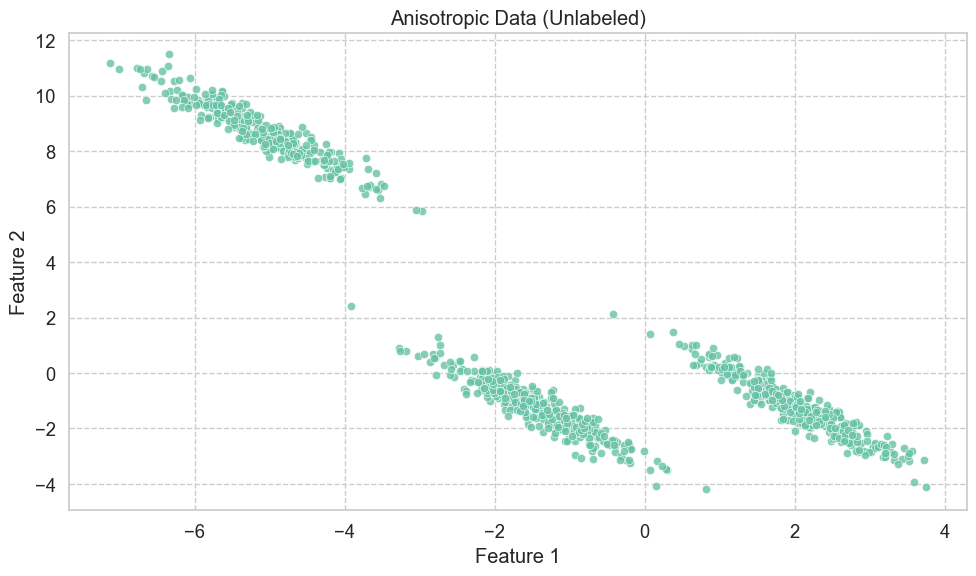

In [5]:
# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)  # type: ignore
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

plt.figure()
sns.scatterplot(x=X_aniso[:, 0], y=X_aniso[:, 1], alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Anisotropic Data (Unlabeled)")
plt.tight_layout()
plt.show()

/Users/changyaochen/Projects/MECE4520/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


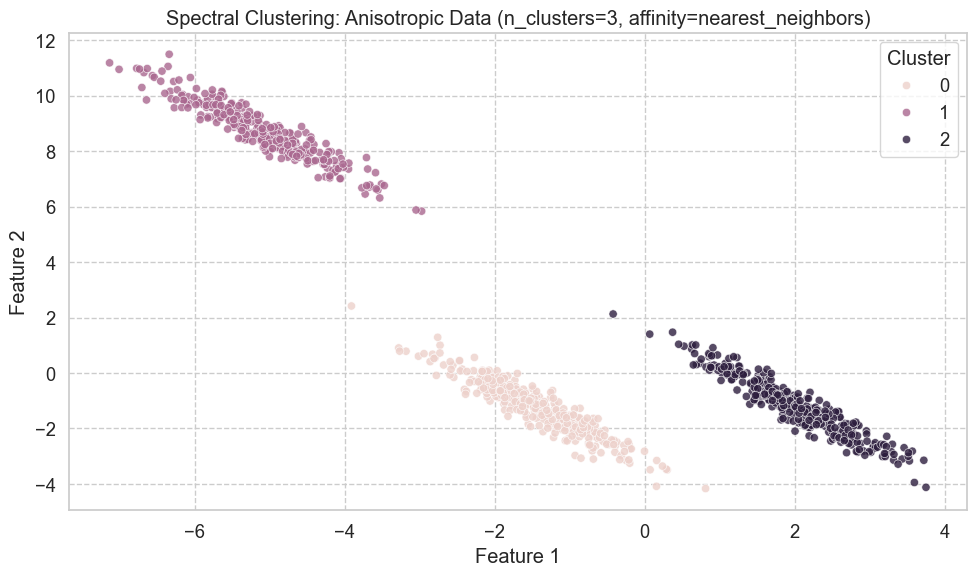

In [6]:
sc = SpectralClustering(
    n_clusters=3,
    affinity="nearest_neighbors",
    random_state=42
)
labels = sc.fit_predict(X_aniso)

plt.figure()
sns.scatterplot(
    x=X_aniso[:, 0],
    y=X_aniso[:, 1],
    hue=labels,
    alpha=0.8
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Spectral Clustering: Anisotropic Data (n_clusters=3, affinity=nearest_neighbors)")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

## Comparison with DBSCAN

DBSCAN is density-based and relies on a single global choice of `eps` and `min_samples`. It can fragment clusters when density varies across the same structure or across clusters. Spectral clustering instead builds a graph of local affinities and partitions it using eigenvectors, so it respects connectivity rather than absolute density.

- **Non-convex structure with uneven density**: DBSCAN often breaks apart sparsely sampled regions; spectral clustering with a k-NN affinity keeps the manifold intact.
- **Uneven sampling and moderate noise**: DBSCAN may label many points as noise or split clusters; spectral clustering is less sensitive if the affinity graph reflects local neighborhoods.
- **Known or acceptable to fix k**: Spectral clustering benefits when the number of clusters can be specified; DBSCAN does not use k and can under/over-cluster under density drift.


Caveats: Spectral clustering requires choosing the number of clusters and an affinity (e.g., k-NN), and can be more computationally demanding on very large datasets. DBSCAN remains a strong choice when densities are comparable and a single `eps` separates clusters well.


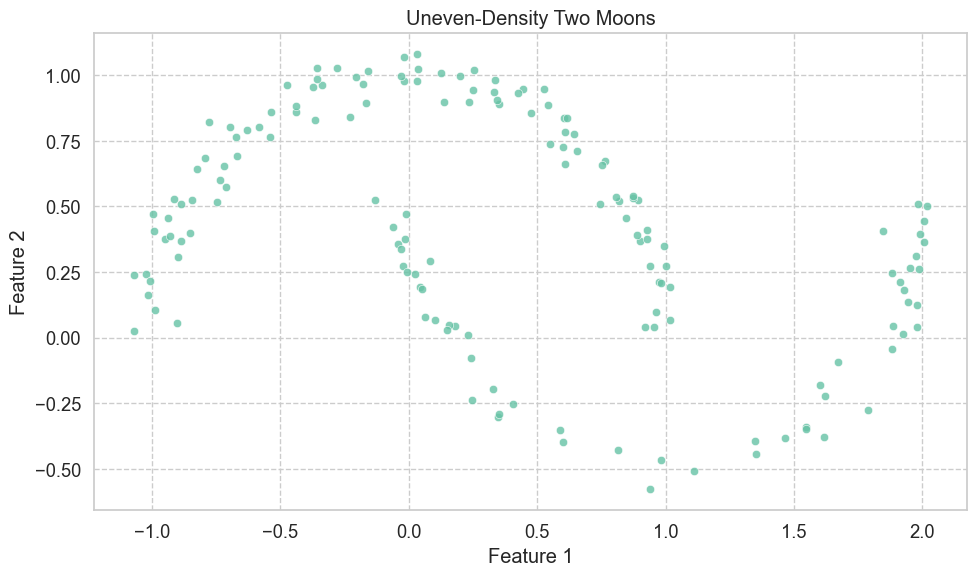

In [7]:
# Spectral clustering over DBSCAN

# Dense moon
X1, _ = datasets.make_moons(n_samples=200, noise=0.05, random_state=0)
# Sparse moon (downsample + stretch slightly)
mask = X1[:, 1] > 0
dense = X1[mask]
sparse = X1[~mask][::3]  # take every 3rd point to make it sparse
X = np.vstack([dense, sparse])

plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Uneven-Density Two Moons")
plt.tight_layout()
plt.show()


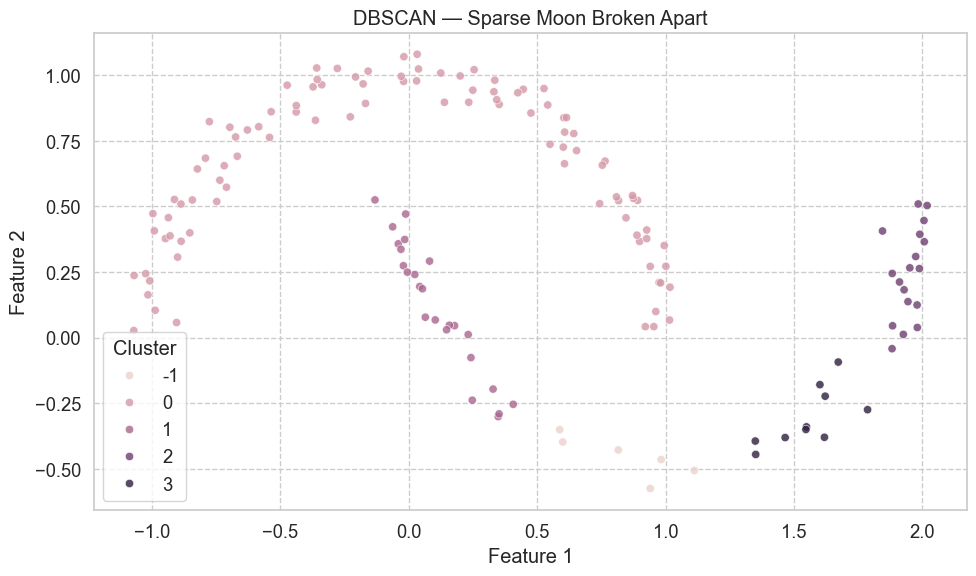

In [8]:
# DBSCAN will not do a good job on this dataset
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5)
labels = db.fit_predict(X)

plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN — Sparse Moon Broken Apart")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

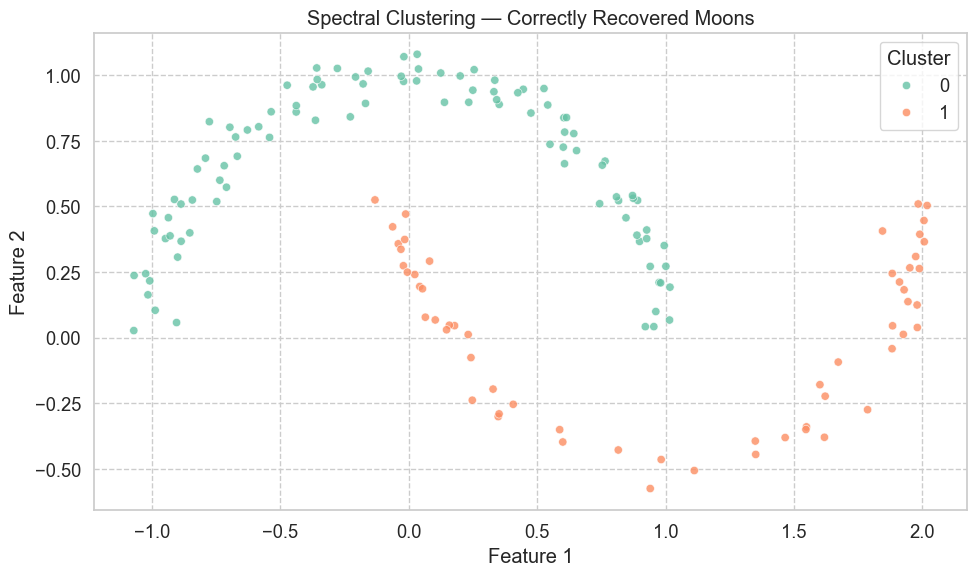

In [9]:
spec = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=8,
    random_state=0
)
spec_labels = spec.fit_predict(X)

plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=spec_labels, alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Spectral Clustering — Correctly Recovered Moons")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()